##### Name: Jayden Hooper
##### ID: 300400481

In [288]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [289]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.drop(['uniqueid'], axis=1, inplace=True)
test.drop(['uniqueid'], axis=1, inplace=True)

### Split data into X & y. Drop arbitrary features.

In [290]:
train_X = train.drop(['bank_account'], axis=1)
train_y = train['bank_account']
test_X = test.drop(['bank_account'], axis=1)
test_y = test['bank_account']

## Explore Training Set

In [291]:
train_X.head()

,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Rural,Yes,4.0,30,Male,Head of Household,Married/Living together,No formal education,Informally employed
1,Rural,Yes,1.0,65,Female,Head of Household,Widowed,No formal education,Farming and Fishing
2,Rural,Yes,3.0,49,Female,Spouse,Married/Living together,Secondary education,Informally employed
3,Urban,Yes,4.0,32,Female,Spouse,Married/Living together,Primary education,Self employed
4,Rural,Yes,7.0,36,Female,Spouse,Married/Living together,Primary education,Informally employed


In [292]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6988 entries, 0 to 6987
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   bank_account            6988 non-null   object 
 1   location_type           6988 non-null   object 
 2   cellphone_access        6988 non-null   object 
 3   household_size          6301 non-null   float64
 4   age_of_respondent       6988 non-null   int64  
 5   gender_of_respondent    6988 non-null   object 
 6   relationship_with_head  6988 non-null   object 
 7   marital_status          6988 non-null   object 
 8   education_level         6988 non-null   object 
 9   job_type                6988 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 546.1+ KB


### Insights into numerical features

There are no null values in our dataset. 
There are some missing values in the feature household_size. 
household_size has come up as a float64 datatype, which potentially indicates the there are some decimal household size values. 
We primarily have categorical variables. 

In [293]:
train.describe()

,household_size,age_of_respondent
count,6301.000000,6988.000000
mean,4.455642,39.397252
std,1.969725,16.266825
min,1.000000,16.000000
25%,3.000000,27.000000
50%,4.000000,35.000000
75%,6.000000,49.000000
max,13.000000,96.000000


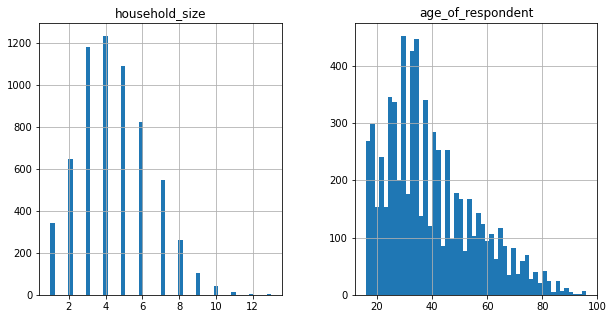

In [294]:
train.hist(bins = 50, figsize = (10,5))
fig = plt.gcf() 

From our summary statistics, we can see household size is approximately normally distributed around 4 people with a low standard deviation of 2. The age of the respondant is skewed slightly to the right. The most commond respondants were between the age of 20-50. 

### Insights into categorical features

In [295]:
from sklearn.compose import make_column_selector as selector


categorical = selector(dtype_include=object)(train_X)

# print the levels of the categorical variables
def levels(df, features):
    [print(i+1, ":", feature, df[feature].unique()) 
     for i, feature in enumerate(features)]

levels(train_X, categorical)

1 : location_type ['Rural' 'Urban']
2 : cellphone_access ['Yes' 'No']
3 : gender_of_respondent ['Male' 'Female']
4 : relationship_with_head ['Head of Household' 'Spouse' 'Child' 'Parent' 'Other non-relatives'
 'Other relative']
5 : marital_status ['Married/Living together' 'Widowed' 'Single/Never Married'
 'Divorced/Seperated']
6 : education_level ['No formal education' 'Secondary education' 'Primary education'
 'Tertiary education' 'Vocational/Specialised training'
 'Other/Dont know/RTA']
7 : job_type ['Informally employed' 'Farming and Fishing' 'Self employed'
 'Formally employed Government' 'Other Income' 'Remittance Dependent'
 'Formally employed Private' 'Government Dependent'
 'Dont Know/Refuse to answer']


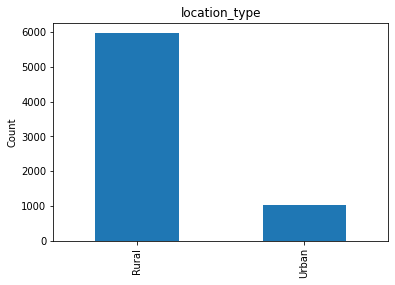

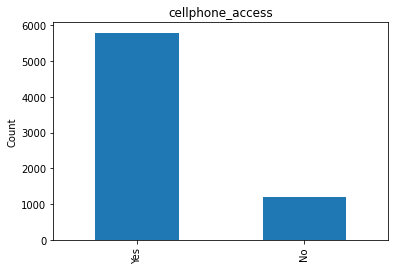

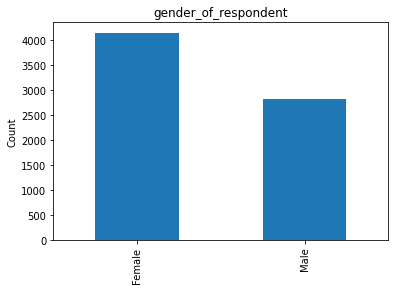

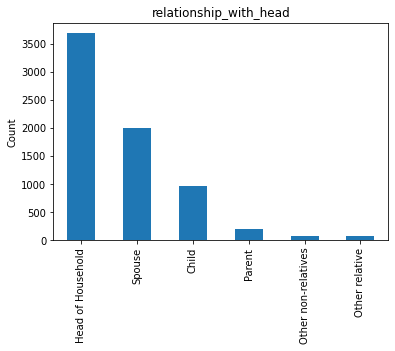

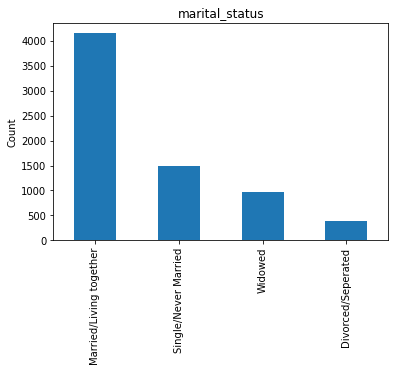

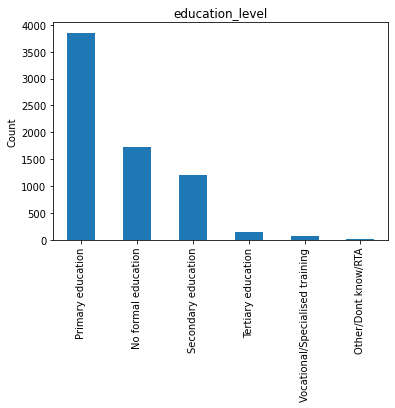

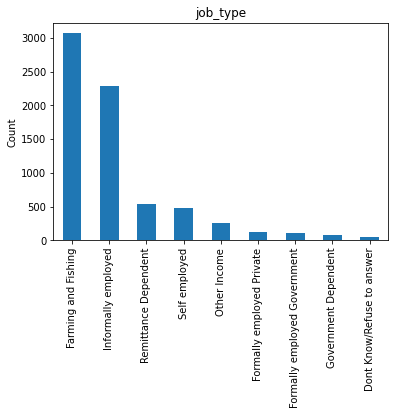

In [296]:
def plot_categorical(df, features):
    for feature in features:
        df[feature].value_counts().plot(kind='bar')
        plt.title(feature)
        plt.ylabel('Count')
        plt.show()
plot_categorical(train_X, categorical)

It would be good to see how these different features interact with whether or not they have a bank account

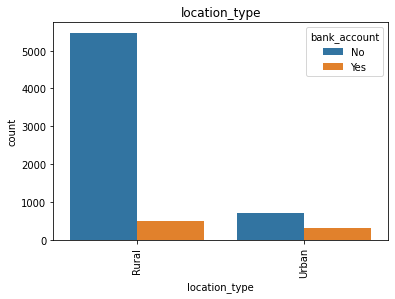

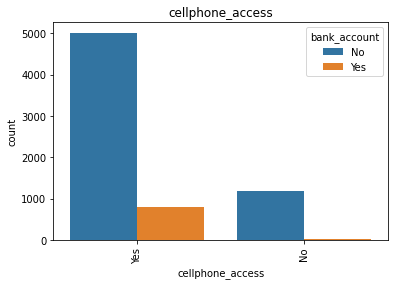

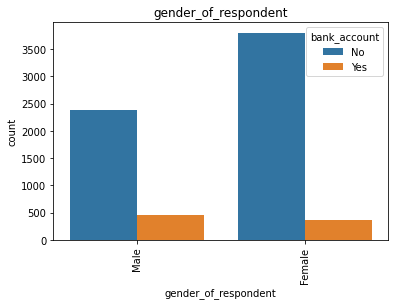

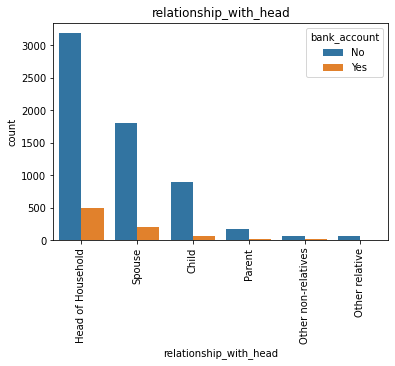

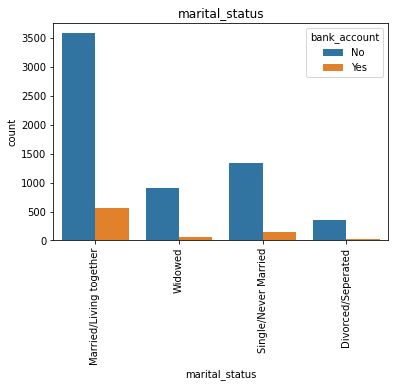

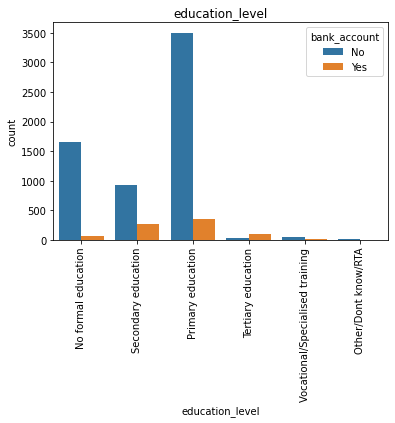

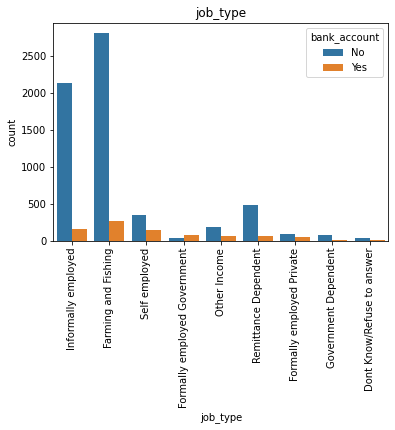

In [297]:
def compare_categorical(df, features, target):
    for feature in features:
        ax = sns.countplot(x=feature, hue=target, data=df)
        ax.tick_params(axis = 'x', rotation = 90)
        plt.title(feature)
        plt.show()
compare_categorical(train_X, categorical, train_y)

From the summary shown above using the countplot, it appears that some categorical features have much more of an affect on whether or not a person has a bank account. These being:

* Location_type. This appears to have the most impact. If you are rural, you much more likely to not have a bank account than if you are urban.
* Cellphone_access. If you do not have cellphone access, you are also very unlikely to have a bank account.

The other features appear to have much less of an effect.

### Proportions

It will likely be useful to look into these comparisons further by looking at the proportion of people with a bank account for each feature.

In [298]:
def calculate_proportions(df, features, target):
    for feature in features:
        prop = df.groupby([feature, target]).size().unstack()
        prop['Proportion'] = prop['Yes'] / (prop['Yes'] + prop['No'])
        display(prop)
calculate_proportions(train_X, categorical, train_y)

bank_account,No,Yes,Proportion
location_type,,,
Rural,5480,488,0.081769
Urban,706,314,0.307843


bank_account,No,Yes,Proportion
cellphone_access,,,
No,1176,17,0.014250
Yes,5010,785,0.135462


bank_account,No,Yes,Proportion
gender_of_respondent,,,
Female,3802,355,0.085398
Male,2384,447,0.157895


bank_account,No,Yes,Proportion
relationship_with_head,,,
Child,896,65,0.067638
Head of Household,3190,500,0.135501
Other non-relatives,63,10,0.136986
Other relative,65,5,0.071429
Parent,173,17,0.089474
Spouse,1799,205,0.102295


bank_account,No,Yes,Proportion
marital_status,,,
Divorced/Seperated,349,30,0.079156
Married/Living together,3585,568,0.136769
Single/Never Married,1347,139,0.093540
Widowed,905,65,0.067010


bank_account,No,Yes,Proportion
education_level,,,
No formal education,1658,61,0.035486
Other/Dont know/RTA,11,4,0.266667
Primary education,3502,352,0.091334
Secondary education,934,265,0.221018
Tertiary education,29,108,0.788321
Vocational/Specialised training,52,12,0.187500


bank_account,No,Yes,Proportion
job_type,,,
Dont Know/Refuse to answer,38,8,0.173913
Farming and Fishing,2807,258,0.084176
Formally employed Government,34,70,0.673077
Formally employed Private,85,45,0.346154
Government Dependent,70,5,0.066667
Informally employed,2137,154,0.067220
Other Income,190,68,0.263566
Remittance Dependent,480,58,0.107807
Self employed,345,136,0.282744


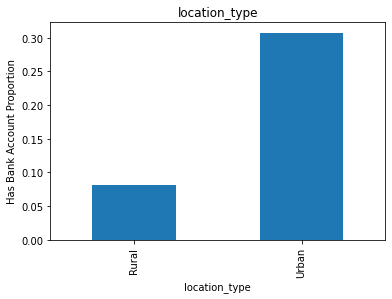

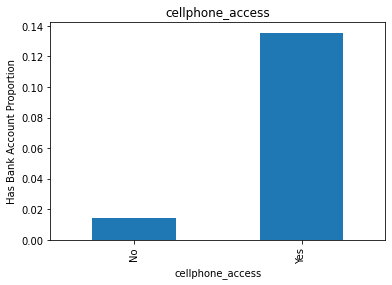

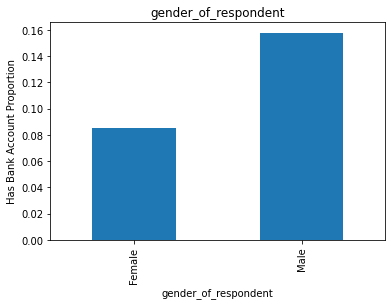

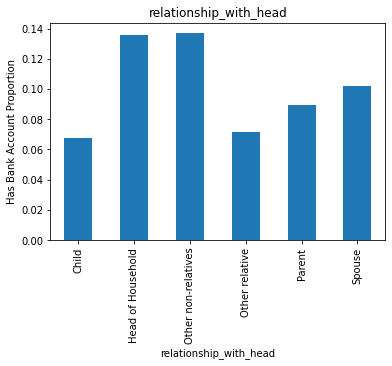

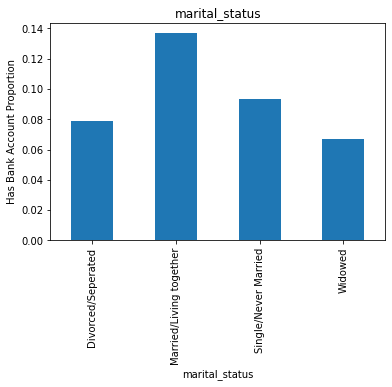

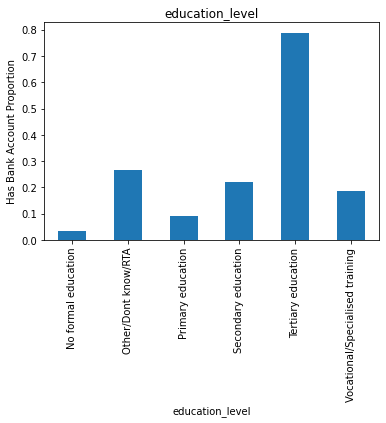

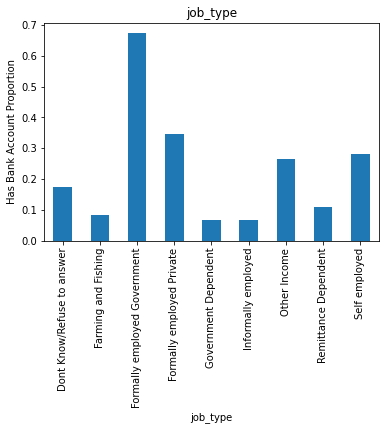

In [299]:
def compare_proportions(df, features, target):
    for feature in features:
        prop = df.groupby([feature, target]).size().unstack()
        prop['Proportion'] = prop['Yes'] / (prop['Yes'] + prop['No'])
        prop['Proportion'].plot(kind='bar')
        plt.title(feature)
        plt.ylabel('Has Bank Account Proportion')
        plt.show()
        
compare_proportions(train_X, categorical, train_y)

From this comparison, it is much more obvious that if you are in the following categories, you are much more likely to have a bank account:
* education level:   Tertiary education
* job type:          Formally Employed Government
* gender:            male
* location type:     urban
* cellphone access:  yes 



## Transform Data

In [300]:
def split_columns(df):
      my_selector = selector(dtype_include=int)
      numerical_int = my_selector(df)
      my_selector = selector(dtype_include=float)
      numerical_float = my_selector(df)
      my_selector = selector(dtype_include=object)
      categorical = my_selector(df)
      return numerical_int, numerical_float, categorical
  
numerical_int, numerical_float, categorical = split_columns(train_X)
print("Features length:", len(train_X.columns), "\nCollected data: ",
      len(numerical_int) + len(categorical) + len(numerical_float))
numerical = numerical_int + numerical_float
print("Numerical: ", len(numerical))
print("Categorical:",len(categorical))

Features length: 9 
Collected data:  9
Numerical:  2
Categorical: 7


We also need to separate the ordinal and nominal features. In this case, there is only education level.

In [301]:
nominal = categorical.copy()
nominal.remove('education_level')
ordinal = ['education_level']

In [302]:
print("Numerical: ", len(numerical))
print("Categorical:",len(categorical))
print("- Nominal:",len(nominal))
print("- Ordinal:",len(ordinal))

Numerical:  2
Categorical: 7
- Nominal: 6
- Ordinal: 1


### Pipelines

In [319]:
def create_default_pipelines():
    numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', StandardScaler())])
    nominal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                ('encoder', OneHotEncoder(handle_unknown='ignore'))])
    ordinal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                ('encoder', OrdinalEncoder(handle_unknown='ignore'))])
    return numerical_pipeline, nominal_pipeline, ordinal_pipeline

In [304]:
numerical_pipeline, nominal_pipeline, ordinal_pipeline = create_default_pipelines()


### Pre-processor and model

#### Function to handle tranformation and model fitting

In [305]:
def create_preprocessor(numerical, nominal, ordinal):
    preprocessor = ColumnTransformer(transformers=[
        ('numerical_transformer', numerical_pipeline, numerical),
        ('nominal_transformer', nominal_pipeline, nominal),
        ('ordinal_trasnformer', ordinal_pipeline, ordinal)])
    return preprocessor

In [310]:
preprocessor = create_preprocessor(numerical, nominal, ordinal)
preprocessor

ColumnTransformer(transformers=[('numerical_transformer',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age_of_respondent', 'household_size']),
                                ('nominal_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['location_type', 'cellphone_access',
                                  'gender_of_respondent',
                                  'relationship_with_head', 'marital_status',
                                  'job_type']),
                                ('ordinal_trasnformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value'))]),
                                 ['education_level'])])

In [311]:
# transform columns and fit the model
lr_model_v1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=800))
])


In [320]:
lr_model_v1.fit(train_X, train_y)
y_train_predicted = lr_model_v1.predict(train_X)

TypeError: unknown_value should be an integer or np.nan when handle_unknown is 'use_encoded_value', got None.